In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import spectral
from bycycle.burst import detect_bursts_cycles, plot_burst_detect_params
from bycycle.features import compute_features
from scipy import stats
from collections import defaultdict
from sklearn.metrics import fbeta_score, precision_score, recall_score

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# A-D. Simulated bursts - components and PSD

In [2]:
# Simulate brown noise + bursts
np.random.seed(0)
f_theta = (4, 10)
freq = np.median(f_theta)
T = 100
Fs = 1000
SNR = 4
lfp, oscillator, brown, df_shape_true = neurodsp.sim_noisy_bursty_oscillator(
    freq, T, Fs, SNR=SNR, return_cycle_df=True, return_components=True)

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

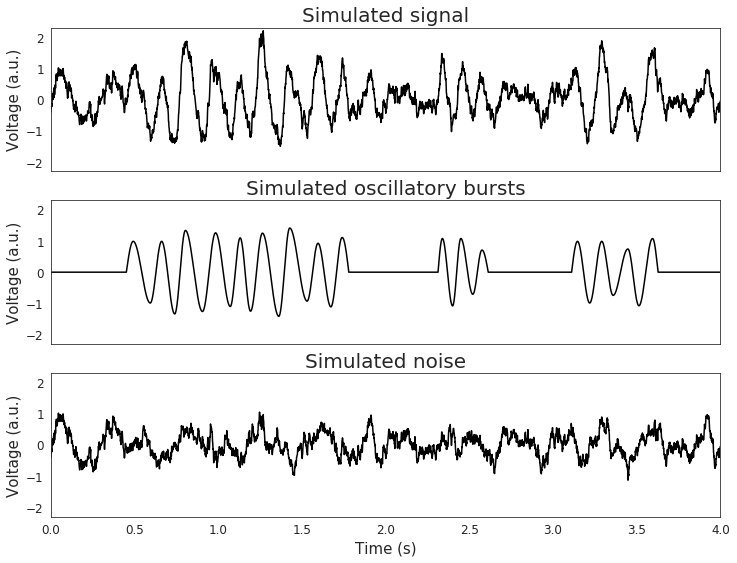

In [3]:
# Plot lfp, oscillator, and brown noise components
t = np.arange(0, T, 1/Fs)
tlim = np.array([31, 35])
tidx = np.logical_and(t>=tlim[0], t<tlim[1])

plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(t[tidx], lfp[tidx], 'k')
plt.xlim(tlim)
plt.ylim((-2.3,2.3))
plt.xticks([])
plt.yticks(size=12)
plt.ylabel('Voltage (a.u.)', size=15)
plt.title('Simulated signal', size=20)

plt.subplot(3,1,2)
plt.plot(t[tidx], oscillator[tidx], 'k')
plt.xlim(tlim)
plt.ylim((-2.3,2.3))
plt.xticks([])
plt.yticks(size=12)
plt.ylabel('Voltage (a.u.)', size=15)
plt.title('Simulated oscillatory bursts', size=20)

plt.subplot(3,1,3)
plt.plot(t[tidx]-tlim[0], brown[tidx], 'k')
plt.xlim(tlim-tlim[0])
plt.ylim((-2.3,2.3))
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Voltage (a.u.)', size=15)
plt.title('Simulated noise', size=20)
plt.xlabel('Time (s)', size=15)
plt.savefig('figs/4ABC_simulated_burst')

In [4]:
f_bandpass = (1, 50)
filter_seconds = (2, .3)
lfp_plt = neurodsp.filter(lfp[tidx], Fs, 'highpass', f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
lfp_plt = neurodsp.filter(lfp_plt, Fs, 'lowpass', f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

Transition bandwidth is 1.0 Hz. Pass/stop bandwidth is 499.0 Hz
Transition bandwidth is 4.9 Hz. Pass/stop bandwidth is 50 Hz


In [5]:
osc_kwargs = {'amplitude_fraction_threshold': 0,
              'amplitude_consistency_threshold': .3,
              'period_consistency_threshold': .6,
              'monotonicity_threshold': .7,
              'N_cycles_min': 3}

df = compute_features(lfp_plt, Fs, f_theta, center_extrema='T',
                      burst_detection_kwargs=osc_kwargs)

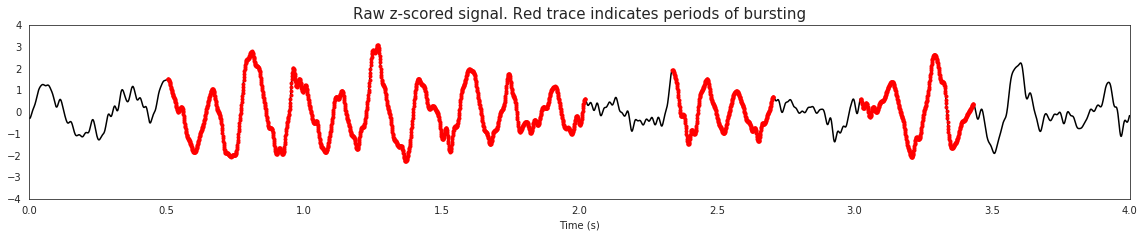

In [6]:
plot_burst_detect_params(lfp_plt, Fs, df, osc_kwargs, plot_only_result=True)

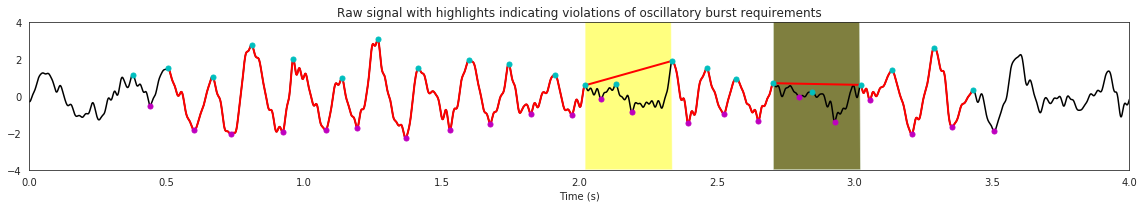

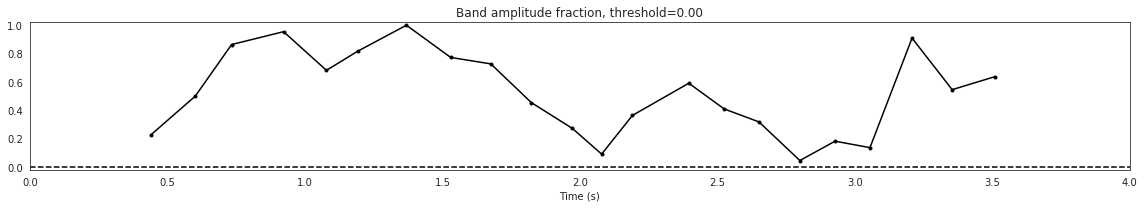

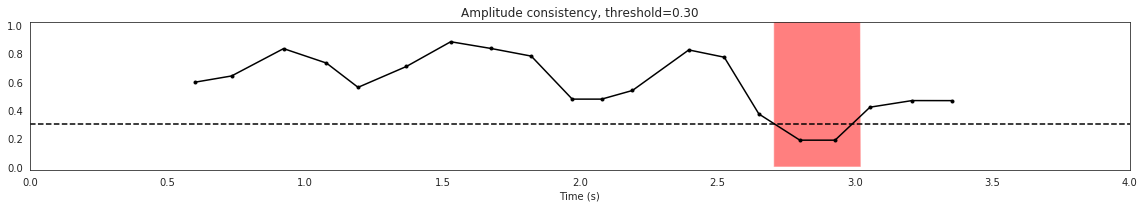

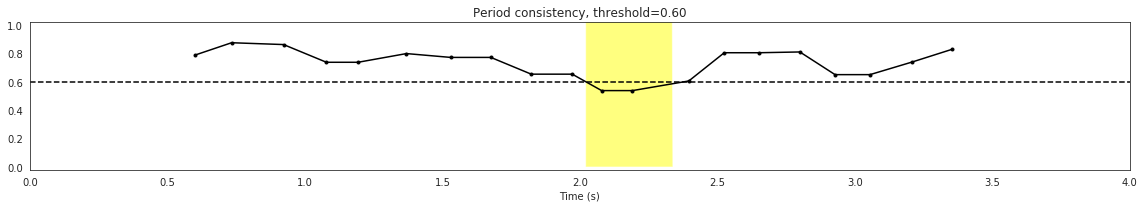

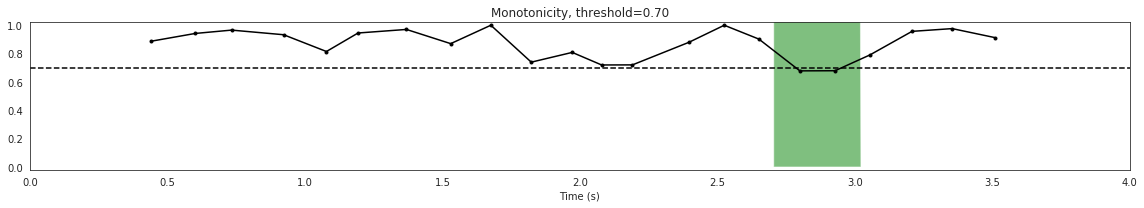

In [7]:
plot_burst_detect_params(lfp_plt, Fs, df, osc_kwargs)

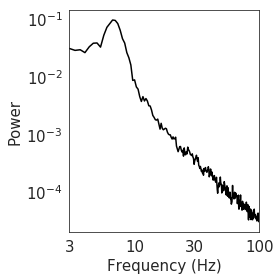

In [8]:
# Compute and plot PSD of simualted signal
f, psd = spectral.psd(lfp, Fs, nperseg=Fs*3)
flim = (3,100)
fidx = np.logical_and(f>=flim[0], f<flim[1])
plt.figure(figsize=(4,4))
plt.loglog(f[fidx], psd[fidx], 'k')
plt.xlabel('Frequency (Hz)', size=15)
plt.ylabel('Power', size=15)
plt.xticks([3, 10, 30, 100], [3, 10, 30, 100], size=15)
plt.yticks(size=15)
plt.xlim(flim)
plt.tight_layout()
plt.savefig('figs/4D_simulated_burst_psd')

# E-H. Precision, recall, F1, and Fbeta score for burst detection accuracy

In [9]:
# Apply 1-25Hz brown bandpass filter
f_bandpass = (1, 25)
filter_seconds = (2, .5)
lfp_filt = neurodsp.filter(lfp, Fs, 'highpass', f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
lfp_filt = neurodsp.filter(lfp_filt, Fs, 'lowpass', f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

Transition bandwidth is 1.0 Hz. Pass/stop bandwidth is 499.0 Hz
Transition bandwidth is 2.9 Hz. Pass/stop bandwidth is 25 Hz


In [10]:
# Decompose signal into cycles
df_shape = compute_features(lfp_filt, Fs, f_theta, center_extrema='T',
                            burst_detection_kwargs=osc_kwargs)

# Define ground truth for oscillating for each cycle based on known simulation
# If the peak of a detected cycle occurs between the troughs
# of a simulated cycle that has is_cycle=True,
# then it is marked as a true cycle. Otherwise, it is marked as not a cycle
is_cycle_true = []
for i, row in df_shape.iterrows():
    is_cycle_true.append(df_shape_true[df_shape_true['start_sample'] < row['sample_trough']].iloc[-1]['is_cycle'])
df_shape['is_burst_true'] = is_cycle_true

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
# Across grid of hyperparameters, determine if each cycle is oscillating, and precision/recall/F1
amp_consist_vals = np.arange(0, 1, .05)
period_consist_vals = np.arange(0, 1, .05)
monotonic_vals = [.5, .8, .95]

osc_dict = defaultdict(list)
for mono_th in monotonic_vals:
    for per_th in period_consist_vals:
        for amp_th in amp_consist_vals:
            
            # Compute if each cycle is oscillating
            osc_kws = {'amplitude_consistency_threshold': amp_th,
                       'period_consistency_threshold': per_th,
                       'monotonicity_threshold': mono_th}
            df_shape = detect_bursts_cycles(df_shape, lfp_filt, **osc_kws)
            
            if df_shape['is_burst'].sum() > 0:
                # Compute precision, recall, and F1
                precision = precision_score(df_shape['is_burst_true'], df_shape['is_burst'])
                recall = recall_score(df_shape['is_burst_true'], df_shape['is_burst'])
                f1 = fbeta_score(df_shape['is_burst_true'], df_shape['is_burst'], 1)
                fp2 = fbeta_score(df_shape['is_burst_true'], df_shape['is_burst'], .2)
            
                # Save results
                osc_dict['precision'].append(precision)
                osc_dict['recall'].append(recall)
                osc_dict['f1'].append(f1)
                osc_dict['fp2'].append(fp2)
            else:
                osc_dict['precision'].append(np.nan)
                osc_dict['recall'].append(np.nan)
                osc_dict['f1'].append(np.nan)
                osc_dict['fp2'].append(np.nan)
                
            osc_dict['amp_consist_thresh'].append(amp_th)
            osc_dict['period_consist_thresh'].append(per_th)
            osc_dict['monotonic_thresh'].append(mono_th)
df_osc = pd.DataFrame(osc_dict)

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


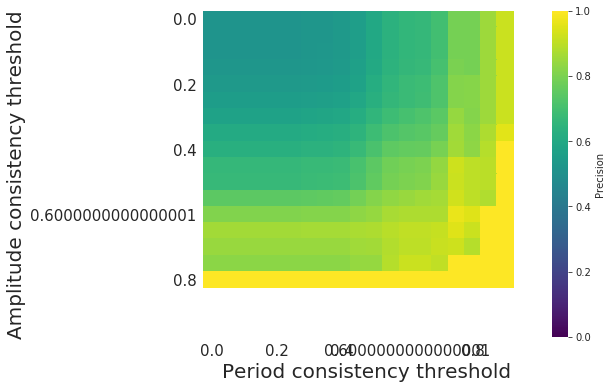

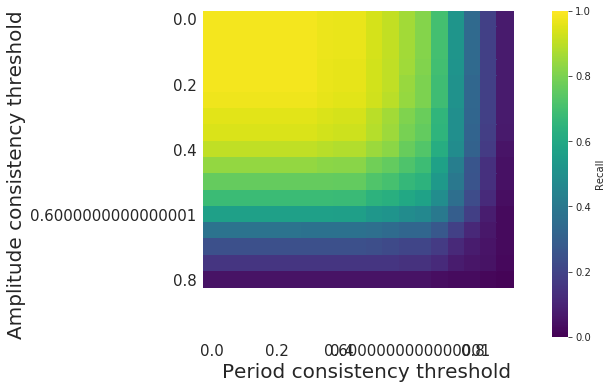

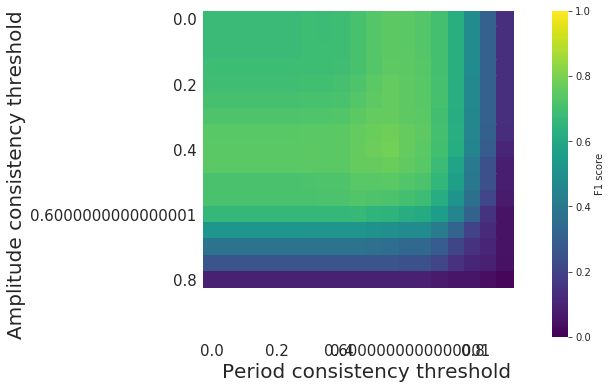

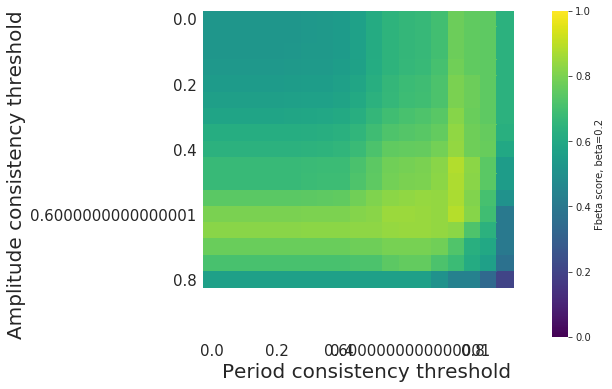

In [12]:
mono_th = monotonic_vals[1]
scores_names = {'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1 score', 'fp2': 'Fbeta score, beta=0.2'}
scores_figletter = {'precision': 'E', 'recall': 'F', 'f1': 'G', 'fp2': 'H'}
for score, name in scores_names.items():
    df_plt = df_osc[df_osc['monotonic_thresh']==mono_th].pivot('amp_consist_thresh', 'period_consist_thresh', score)
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df_plt, vmin=0, vmax=1, cmap=cm.viridis, xticklabels=4, yticklabels=4, square=True,
                     cbar_kws={'label': name, 'ticks':np.arange(0,1.2,.2)}, mask = df_plt.isnull())
    plt.xlabel('Period consistency threshold', size=20)
    plt.ylabel('Amplitude consistency threshold', size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.savefig('figs/4{:s}_oscillating_params_vs_{:s}.png'.format(scores_figletter[score], score))

In [15]:
# Determine period and amp consistency parameter with max F1
max_period_param_f1 = df_osc[df_osc['monotonic_thresh']==mono_th].pivot(
    'amp_consist_thresh', 'period_consist_thresh', 'f1').max().idxmax()
max_amp_param_f1 = df_osc[df_osc['monotonic_thresh']==mono_th].pivot(
    'amp_consist_thresh', 'period_consist_thresh', 'f1').max(axis=1).idxmax()
print('f1 amp_th, period_th', max_period_param_f1, max_amp_param_f1)

# Determine period and amp consistency parameter with max Fbeta
max_period_param_fp2 = df_osc[df_osc['monotonic_thresh']==mono_th].pivot(
    'amp_consist_thresh', 'period_consist_thresh', 'fp2').max().idxmax()
max_amp_param_fp2 = df_osc[df_osc['monotonic_thresh']==mono_th].pivot(
    'amp_consist_thresh', 'period_consist_thresh', 'fp2').max(axis=1).idxmax()
print('fp2 amp_th, period_th', max_period_param_fp2, max_amp_param_fp2)

# Determine the precision and recall that maximize F1 and Fbeta
print('f1 precision', df_osc[(df_osc['monotonic_thresh']==mono_th) & 
                             (df_osc['amp_consist_thresh']==max_amp_param_f1) & 
                             (df_osc['period_consist_thresh']==max_period_param_f1)]['precision'].values[0])

print('f1 recall', df_osc[(df_osc['monotonic_thresh']==mono_th) & 
                             (df_osc['amp_consist_thresh']==max_amp_param_f1) & 
                             (df_osc['period_consist_thresh']==max_period_param_f1)]['recall'].values[0])

print('fbeta precision', df_osc[(df_osc['monotonic_thresh']==mono_th) & 
                             (df_osc['amp_consist_thresh']==max_amp_param_fp2) & 
                             (df_osc['period_consist_thresh']==max_period_param_fp2)]['precision'].values[0])

print('fbeta recall', df_osc[(df_osc['monotonic_thresh']==mono_th) & 
                             (df_osc['amp_consist_thresh']==max_amp_param_fp2) & 
                             (df_osc['period_consist_thresh']==max_period_param_fp2)]['recall'].values[0])

f1 amp_th, period_th 0.55 0.4
fp2 amp_th, period_th 0.75 0.6000000000000001
f1 precision 0.752906976744186
f1 recall 0.8248407643312102
fbeta precision 0.968421052631579
fbeta recall 0.2929936305732484


# I-K. Correlation between simulated individual cycle amp, period, and rdsym

In [16]:
# Recompute the shape features using the parameters that maximize f_beta
osc_kws = {'amplitude_consistency_threshold': max_amp_param_fp2,
           'period_consistency_threshold': max_period_param_fp2,
           'monotonicity_threshold': mono_th}
df_shape = detect_bursts_cycles(df_shape, lfp_filt, **osc_kws)

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
# Define ground truth for rdsym, amp, and period of each cycle
df_shape_cycles = df_shape[df_shape['is_burst_true'] & df_shape['is_burst']]
true_rdsym = []
true_amp = []
true_period = []
for i, row in df_shape_cycles.iterrows():
    row_oi = df_shape_true[df_shape_true['start_sample'] < row['sample_trough']].iloc[-1]
    true_rdsym.append(row_oi['rdsym'])
    true_amp.append(row_oi['amp'])
    true_period.append(row_oi['period'])
    
df_shape_cycles['rdsym_true'] = true_rdsym
df_shape_cycles['rdsym_pred'] = df_shape_cycles['time_rdsym']
df_shape_cycles['amp_true'] = np.array(true_amp) * 2
df_shape_cycles['amp_pred'] = df_shape_cycles['volt_amp']
df_shape_cycles['period_true'] = true_period
df_shape_cycles['period_pred'] = df_shape_cycles['period']

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

amp SpearmanrResult(correlation=0.63659201948122, pvalue=9.081220153783716e-12)
period SpearmanrResult(correlation=0.8240549407318862, pvalue=6.224825162799033e-24)
rdsym SpearmanrResult(correlation=0.6724258175836197, pvalue=2.1377914518300416e-13)


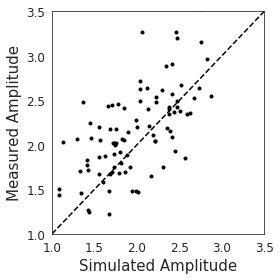

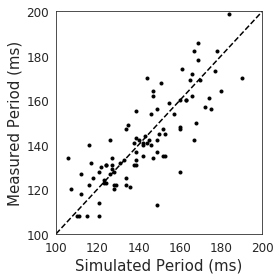

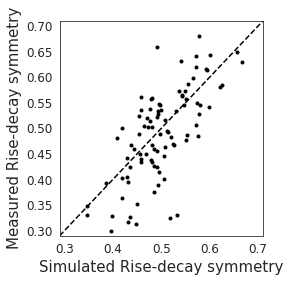

In [19]:
feat_names = {'amp': 'Amplitude', 'period': 'Period (ms)', 'rdsym': 'Rise-decay symmetry'}
feat_figletter = {'amp': 'I', 'period': 'J', 'rdsym': 'K'}
feat_lims = {'amp': (1,3.5), 'period': (100, 200), 'rdsym': (.29, .71)}

for feat, name in feat_names.items():
    print(feat, stats.spearmanr(df_shape_cycles[feat+'_true'], df_shape_cycles[feat+'_pred']))
    plt.figure(figsize=(4,4))
    plt.plot(df_shape_cycles[feat+'_true'], df_shape_cycles[feat+'_pred'], 'k.')
    plt.plot([feat_lims[feat][0], feat_lims[feat][1]], [feat_lims[feat][0], feat_lims[feat][1]], 'k--')
    plt.xlabel('Simulated {:s}'.format(name), size=15)
    plt.ylabel('Measured {:s}'.format(name), size=15)
    plt.xlim(feat_lims[feat])
    plt.ylim(feat_lims[feat])
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig('figs/4{:s}_oscillating_params_vs_{:s}.png'.format(feat_figletter[feat], feat))